In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    utils,
    metrics,
    losses,
    optimizers,
)

from scipy.stats import norm
import pandas as pd
import os
import librosa

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# CLEAR GPU MEMORY
from numba import cuda
device = cuda.get_current_device()
device.reset()

In [ ]:
def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=4, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


## 0. Parameters <a name="parameters"></a>

In [ ]:
IMAGE_SIZE_Y = 1312
IMAGE_SIZE_X = 1056
CHANNELS = 1
BATCH_SIZE = 16
NUM_FEATURES = 512
Z_DIM = 512
LEARNING_RATE = 0.000005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False

## 1. Prepare the data <a name="prepare"></a>

In [ ]:
!unzip ./music.zip

unzip:  cannot find or open ./music.zip, ./music.zip.zip or ./music.zip.ZIP.


In [ ]:
!unzip ./spec_images_labelled.zip

In [ ]:
!unzip ./spectogram_labelled.zip

In [ ]:
train_data = []

def load(f):
    arr = np.load(f, allow_pickle=True)
    if (arr.shape == (1025, 1293)):
        arr = librosa.amplitude_to_db(arr)
        arr = np.pad(arr, (0, 19), 'edge')
        z = np.zeros((12, arr.shape[1]))
        arr = np.concatenate((arr, z))
        arr = np.expand_dims(arr, 2)
        print(arr.shape)
        train_data.append(arr)

directory = "./spectogram_labelled"
i=0
for filename in os.listdir(directory):
    #print(f)
    f = os.path.join(directory, filename)
    # checking if it is a file
    #print(f)
    if (i >= 50):
      break
    if os.path.isfile(f):
        load(f)
        i += 1

#train_data = np.array(train_data)
#print(train_data.shape)
#IMAGE_SIZE = train_data[0].shape

train = np.array(train_data)

print(len(train_data))

<ipython-input-16-7bd6c41a4443>:6: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  arr = librosa.amplitude_to_db(arr)


(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
(1056, 1312, 1)
50


In [ ]:
# Load the data
train_data = utils.image_dataset_from_directory(
    "./spec_images_labelled",
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE_X, IMAGE_SIZE_Y),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 0 files belonging to 1 classes.


ValueError: ignored

In [ ]:
# Preprocess the data
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img


train = train_data.map(lambda x: preprocess(x))

print(len(train))

249


In [ ]:
train_sample = sample_batch(train)

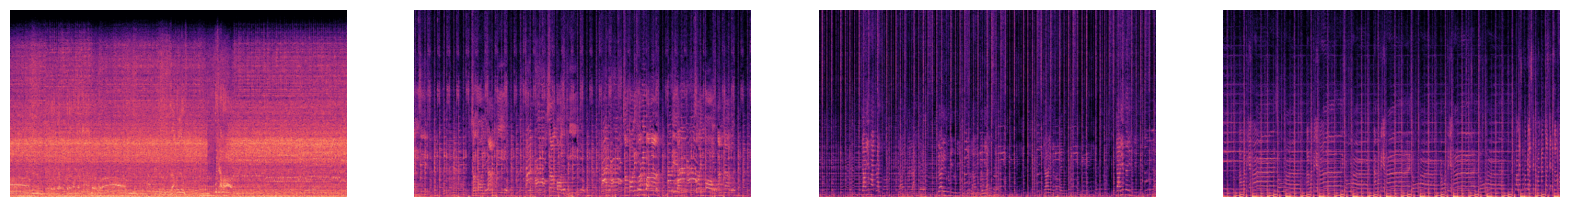

In [ ]:
# Show some faces from the training set
display(train_sample, cmap=None)

## 2. Build the variational autoencoder <a name="build"></a>

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Encoder
encoder_input = layers.Input(
    shape=(IMAGE_SIZE_X, IMAGE_SIZE_Y, CHANNELS), name="encoder_input"
)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(
    encoder_input
)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(NUM_FEATURES, kernel_size=3, strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]  # the decoder will need this!

x = layers.Flatten()(x)
z_mean = layers.Dense(Z_DIM, name="z_mean")(x)
z_log_var = layers.Dense(Z_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 1056, 1312, 1)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 528, 656, 512)        5120      ['encoder_input[0][0]']       
                                                                                                  
 batch_normalization (Batch  (None, 528, 656, 512)        2048      ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 528, 656, 512)        0         ['batch_normalization[0]

In [ ]:
# Decoder
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=1, padding="same"
)(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2DTranspose(
    NUM_FEATURES, kernel_size=3, strides=2, padding="same"
)(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
decoder_output = layers.Conv2DTranspose(
    CHANNELS, kernel_size=3, strides=1, activation="sigmoid", padding="same"
)(x)
decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 512)]             0         
                                                                 
 dense (Dense)               (None, 692736)            355373568 
                                                                 
 batch_normalization_5 (Bat  (None, 692736)            2770944   
 chNormalization)                                                
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 692736)            0         
                                                                 
 reshape (Reshape)           (None, 33, 41, 512)       0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 66, 82, 512)       2359808   
 anspose)                                                    

In [ ]:
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def call(self, inputs):
        """Call the model on a particular input."""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        """Step run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data, training=True)
            reconstruction_loss = tf.reduce_mean(
                BETA * losses.mean_squared_error(data, reconstruction)
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1,
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        """Step run during validation."""
        if isinstance(data, tuple):
            data = data[0]

        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
            BETA * losses.mean_squared_error(data, reconstruction)
        )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1,
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
# Create a variational autoencoder
vae = VAE(encoder, decoder)

## 3. Train the variational autoencoder <a name="train"></a>

In [ ]:
# Compile the variational autoencoder
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
vae.compile(optimizer=optimizer)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only=False,
    save_freq="epoch",
    monitor="loss",
    mode="min",
    save_best_only=True,
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.decoder(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = utils.array_to_img(generated_images[i])
            img.save("./output/generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
# Load old weights if required
if LOAD_MODEL:
    vae.load_weights("./models/vae")
    tmp = vae.predict(train.take(1))

In [ ]:
class My_Custom_Generator(utils.Sequence) :

  def __init__(self, image, batch_size) :
    self.image = image
    self.batch_size = batch_size


  def __len__(self) :
    return (np.ceil(len(self.image) / float(self.batch_size))).astype(np.int32)


  def __getitem__(self, idx) :
    batch_x = self.image[idx * self.batch_size : (idx+1) * self.batch_size]

    return np.array(batch_x)

In [ ]:
batch_size = 2

my_training_batch_generator = My_Custom_Generator(train, batch_size)

print(train.shape)

(50, 1056, 1312, 1)


In [ ]:
vae.fit_generator(
    generator=my_training_batch_generator,
    steps_per_epoch = int(50 // batch_size),
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
    ],
)

NameError: ignored

In [ ]:
# Save the final models
vae.save("./models/vae")
encoder.save("./models/encoder")
decoder.save("./models/decoder")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [ ]:
# Select a subset of the test set
batches_to_predict = 1
example_images = np.array(
    list(train.take(batches_to_predict).get_single_element())
)

4/4 [==============================] - 0s 19ms/step
Example real faces


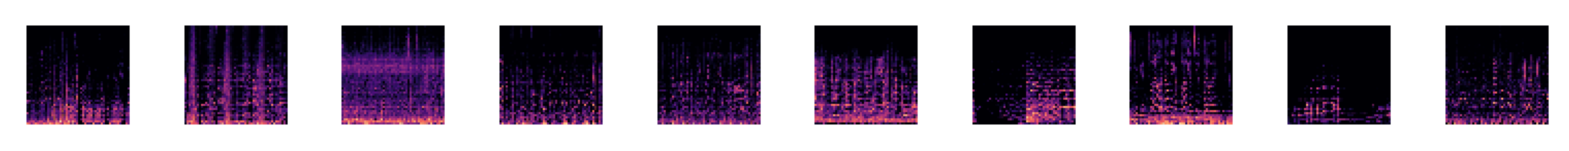

Reconstructions


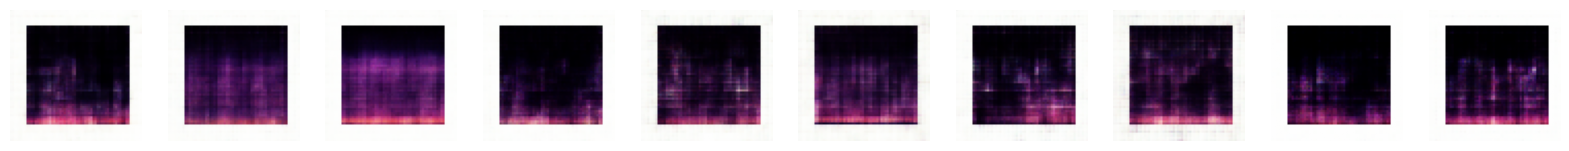

In [ ]:
from PIL import Image

# Create autoencoder predictions and display
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print("Example real faces")
example_images = (example_images*255).astype(np.uint8)
display(example_images)
for i in range(0,len(example_images)):
  IMG = Image.fromarray(example_images[i])
  IMG = IMG.save("./outImages/INPUT_"+str(i)+".jpg")
print("Reconstructions")
reconstructions = (reconstructions*255).astype(np.uint8)
display(reconstructions)
for i in range(0,len(reconstructions)):
  IMG = Image.fromarray(reconstructions[i])
  IMG = IMG.save("./outImages/OUTPUT_"+str(i)+".jpg")

In [ ]:
!zip ./outImages.zip -r ./outImages

In [ ]:
!zip ./models.zip -r ./models

updating: models/ (stored 0%)
updating: models/decoder/ (stored 0%)
updating: models/decoder/saved_model.pb (deflated 87%)
updating: models/decoder/variables/ (stored 0%)
updating: models/decoder/variables/variables.index (deflated 50%)
updating: models/decoder/variables/variables.data-00000-of-00001 (deflated 6%)
updating: models/decoder/keras_metadata.pb (deflated 88%)
updating: models/decoder/fingerprint.pb (stored 0%)
updating: models/decoder/assets/ (stored 0%)
updating: models/encoder/ (stored 0%)
updating: models/encoder/saved_model.pb (deflated 88%)
updating: models/encoder/variables/ (stored 0%)
updating: models/encoder/variables/variables.index (deflated 54%)
updating: models/encoder/variables/variables.data-00000-of-00001 (deflated 8%)
updating: models/encoder/keras_metadata.pb (deflated 90%)
updating: models/encoder/fingerprint.pb (stored 0%)
updating: models/encoder/assets/ (stored 0%)
updating: models/vae/ (stored 0%)
updating: models/vae/saved_model.pb (deflated 88%)
upd

## 4. Genre Interpolation


In [ ]:
#vae = vae.save("./models/vae")
encoder = encoder.save("./encoder")
decoder = decoder.save("./decoder")

In [ ]:
! unzip ./spec_images_labelled.zip

In [ ]:
def morph_images(image1, image2, encoder, decoder):


    factors = np.arange(0, 1, 0.1)

    example_images = [image1, image2]
    _, _, z_points = encoder.predict(example_images, verbose=0)

    fig = plt.figure(figsize=(18, 8))

    counter = 1

    img = example_images[0]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    counter += 1

    for factor in factors:
        changed_z_point = z_points[0] * (1 - factor) + z_points[1] * factor
        changed_image = decoder.predict(
            np.array([changed_z_point]), verbose=0
        )[0]
        sub = fig.add_subplot(1, len(factors) + 2, counter)
        sub.axis("off")
        sub.imshow(changed_image)

        counter += 1

    img = example_images[1]
    sub = fig.add_subplot(1, len(factors) + 2, counter)
    sub.axis("off")
    sub.imshow(img)

    plt.show()


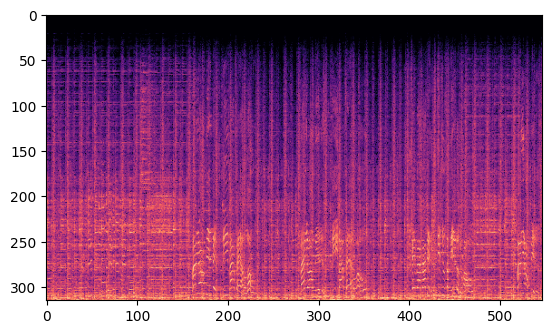

In [ ]:
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import random

Target_genre = "blues"

#input_spec_image = img

target_genre_img_list = []

directory = "./spec_images_labelled"

first = True
testimage = []
count = 0
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        name = (f.split(".")[1]).split("/")[1]
        if (name.split("_")[0] == Target_genre and f.split(".")[-1] == "png"):
          target_genre_img_list.append(np.array(Image.open(f)))

target_genre_img = random.choice(target_genre_img_list)

plt.imshow(target_genre_img)

morph_image(img, target_genre_img, encoder, decoder)